In [1]:
from scipy.ndimage.interpolation import zoom
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}
plt.rcParams['figure.figsize'] = 8,8

Using TensorFlow backend.


In [2]:
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

def grad_cam(input_model, image, layer_name,H=224,W=224):
    cls = np.argmax(input_model.predict(image))
    """GradCAM method for visualizing input saliency."""
    
    y_c = input_model.output[0, cls]
    
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]

    gradient_function = K.function([input_model.input], [conv_output, grads])
    
    output, grads_val = gradient_function([image])
    
    output, grads_val = output[0], grads_val[0]
    
    weights = np.mean(grads_val, axis=(0, 1))
    
    cam = np.dot(output, weights)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    cam = zoom(cam,H/cam.shape[0])
    return cam

In [3]:
def grad_cam_plus(input_model, img, layer_name,H=224,W=224):

    cls = np.argmax(input_model.predict(img))
    y_c = input_model.output[0, cls]
    conv_output = input_model.get_layer(layer_name).output
    grads = K.gradients(y_c, conv_output)[0]
    
    first = K.exp(y_c)*grads
    second = K.exp(y_c)*grads*grads
    third = K.exp(y_c)*grads*grads

    gradient_function = K.function([input_model.input], [y_c,first,second,third, conv_output, grads])
    y_c, conv_first_grad, conv_second_grad,conv_third_grad, conv_output, grads_val = gradient_function([img])
    global_sum = np.sum(conv_output[0].reshape((-1,conv_first_grad[0].shape[2])), axis=0)

    alpha_num = conv_second_grad[0]
    alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum.reshape((1,1,conv_first_grad[0].shape[2]))
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, np.ones(alpha_denom.shape))
    alphas = alpha_num/alpha_denom

    weights = np.maximum(conv_first_grad[0], 0.0)

    alpha_normalization_constant = np.sum(np.sum(alphas, axis=0),axis=0)

    alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))

    deep_linearization_weights = np.sum((weights*alphas).reshape((-1,conv_first_grad[0].shape[2])),axis=0)
    grad_CAM_map = np.sum(deep_linearization_weights*conv_output[0], axis=2)

    cam = np.maximum(grad_CAM_map, 0)
    cam = zoom(cam,H/cam.shape[0])
    cam = cam / np.max(cam) # scale 0 to 1.0    
    
    return cam

In [4]:
from keras import backend as K
K.clear_session()

VGG_model = VGG16(weights='imagenet')
VGG_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

grad_cam_images/cat_dog.png
class activation map for: [('n02108089', 'boxer', 0.4201416), ('n02108422', 'bull_mastiff', 0.28162327)]
(224, 224, 3)


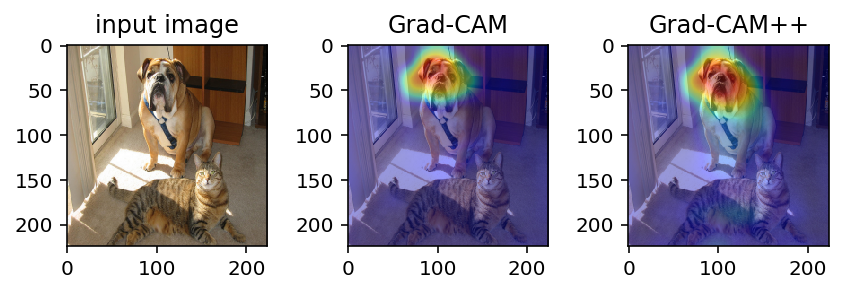

grad_cam_images/multiple_dogs.jpg
class activation map for: [('n02090622', 'borzoi', 0.20189764), ('n02095314', 'wire-haired_fox_terrier', 0.19200516)]
(224, 224, 3)


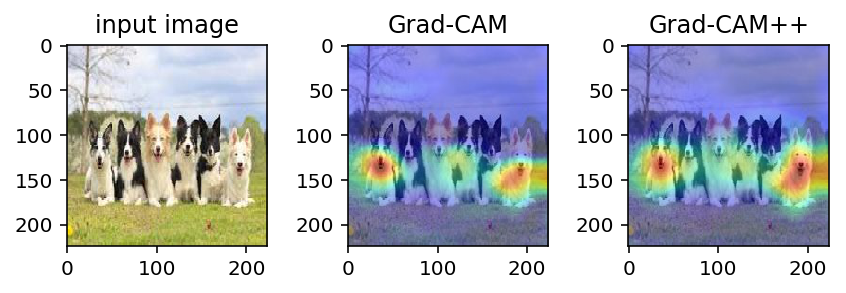

grad_cam_images/collies.JPG
class activation map for: [('n02106166', 'Border_collie', 0.6747878), ('n02106030', 'collie', 0.25649846)]
(224, 224, 3)


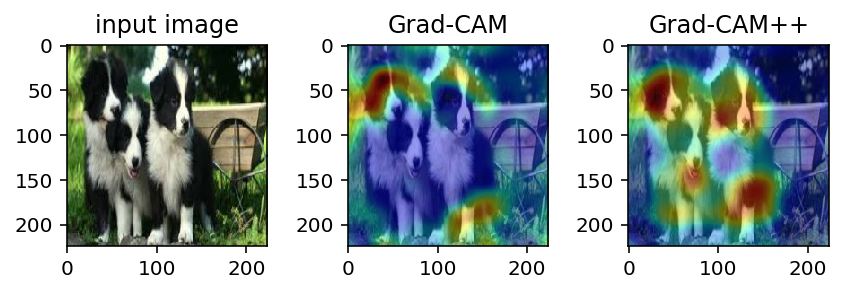

grad_cam_images/snake.JPEG
class activation map for: [('n01751748', 'sea_snake', 0.53460854), ('n01737021', 'water_snake', 0.14084609)]
(224, 224, 3)


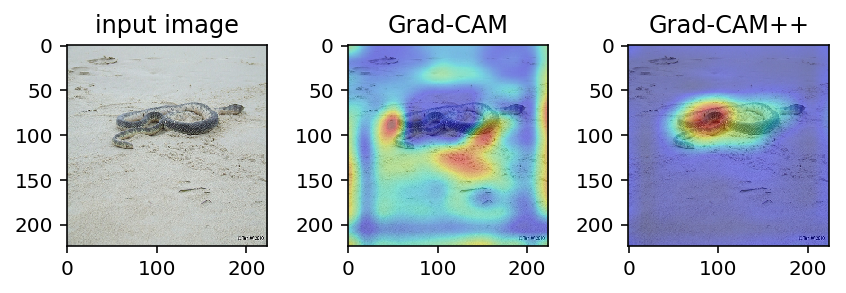

grad_cam_images/water-bird.JPEG
class activation map for: [('n02006656', 'spoonbill', 0.99993765), ('n02007558', 'flamingo', 3.277104e-05)]
(224, 224, 3)


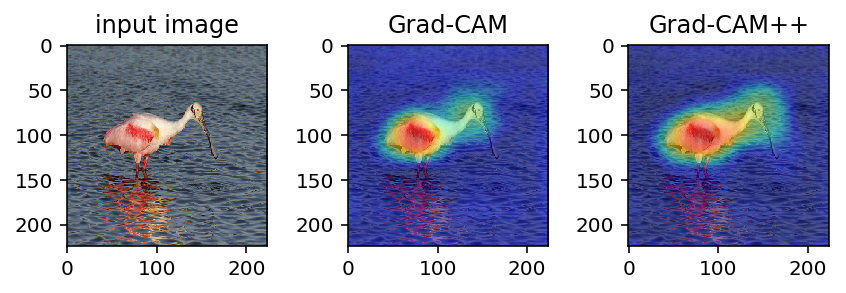

grad_cam_images/elephant.jpg
class activation map for: [('n02504458', 'African_elephant', 0.9094213), ('n01871265', 'tusker', 0.08618258)]
(224, 224, 3)


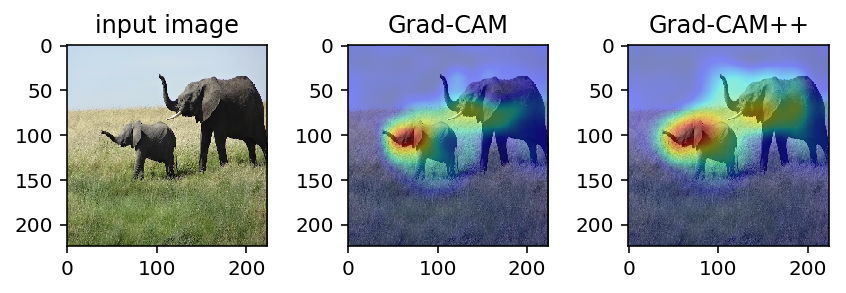

grad_cam_images/nezumi.jpeg
class activation map for: [('n02441942', 'weasel', 0.32210317), ('n02326432', 'hare', 0.118073024)]
(224, 224, 3)


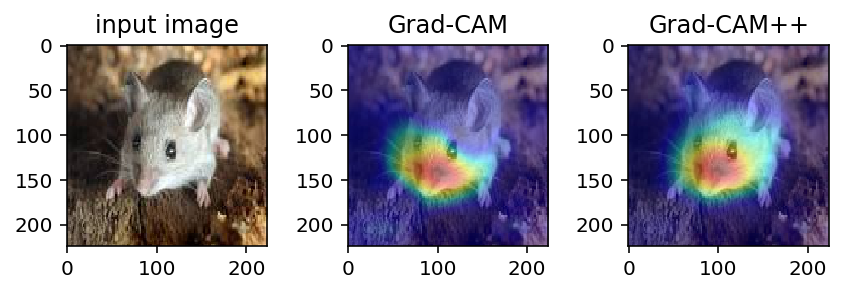

In [6]:
paths = ["cat_dog.png", "multiple_dogs.jpg", "collies.JPG", "snake.JPEG", "water-bird.JPEG", "elephant.jpg", "nezumi.jpeg"]

for path in paths:
    path = os.path.join("grad_cam_images",path)
    orig_img = np.array(load_img(path,target_size=(224,224)),dtype=np.uint8)
    img = np.array(load_img(path,target_size=(224,224)),dtype=np.float64)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    predictions = VGG_model.predict(img)
    top_n = 5
    top = decode_predictions(predictions, top=top_n)[0]
    cls = np.argsort(predictions[0])[-top_n:][::-1]
    
    img = np.array(load_img(path,target_size=(224,224)),dtype=np.float64)
    img = np.expand_dims(img,axis=0)
    img = preprocess_input(img)
    predictions = VGG_model.predict(img)
    top_n = 5
    top = decode_predictions(predictions, top=top_n)[0]
    cls = np.argsort(predictions[0])[-top_n:][::-1]
    
    gradcam=grad_cam(VGG_model,img,layer_name='block5_conv3')
    gradcamplus=grad_cam_plus(VGG_model,img,layer_name='block5_conv3')
    print(path)
    print("class activation map for:",top[:2])
    
    fig, ax = plt.subplots(nrows=1,ncols=3)
    plt.subplot(131)
    plt.imshow(orig_img)
    print(orig_img.shape)
    
    plt.title("input image")
    plt.subplot(132)
    plt.imshow(orig_img)
    plt.imshow(gradcam,alpha=0.4,cmap="jet")
    plt.title("Grad-CAM")
    plt.subplot(133)
    plt.imshow(orig_img)
    plt.imshow(gradcamplus,alpha=0.4,cmap="jet")
    plt.title("Grad-CAM++")
    plt.tight_layout() 
    plt.show()

<hr/>